In [180]:
import sklearn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [101]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, accuracy_score
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix, classification_report
from sklearn.metrics import roc_curve, auc, f1_score
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.model_selection import GridSearchCV, cross_val_score, cross_val_predict
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, plot_tree
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.svm import SVC

In [102]:
import warnings
from sklearn.exceptions import ConvergenceWarning

In [103]:
df = pd.read_csv("cannabis_full.csv")
df = pd.DataFrame(df)
df = df.dropna()
df.head(3)

,Strain,Type,Rating,Effects,Flavor,Creative,Energetic,Tingly,Euphoric,Relaxed,...,Ammonia,Minty,Tree,Fruit,Butter,Pineapple,Tar,Rose,Plum,Pear
0,100-Og,hybrid,4.0,"Creative,Energetic,Tingly,Euphoric,Relaxed","Earthy,Sweet,Citrus",1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,98-White-Widow,hybrid,4.7,"Relaxed,Aroused,Creative,Happy,Energetic","Flowery,Violet,Diesel",1.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1024,sativa,4.4,"Uplifted,Happy,Relaxed,Energetic,Creative","Spicy/Herbal,Sage,Woody",1.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Part One: Binary Classification

In [104]:
df_ = df[df['Type'].isin(['sativa', 'indica'])]
df_ = df_.dropna()
df_.head(3)

,Strain,Type,Rating,Effects,Flavor,Creative,Energetic,Tingly,Euphoric,Relaxed,...,Ammonia,Minty,Tree,Fruit,Butter,Pineapple,Tar,Rose,Plum,Pear
2,1024,sativa,4.4,"Uplifted,Happy,Relaxed,Energetic,Creative","Spicy/Herbal,Sage,Woody",1.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,303-Og,indica,4.2,"Relaxed,Happy,Euphoric,Uplifted,Giggly","Citrus,Pungent,Earthy",0.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,3D-Cbd,sativa,4.6,"Uplifted,Focused,Happy,Talkative,Relaxed","Earthy,Woody,Flowery",0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [105]:
#Universal Column Transformer

ct = ColumnTransformer(
    [("dm", OneHotEncoder(sparse_output = False, handle_unknown = 'ignore'),
      make_column_selector(dtype_include = object)),
     ("st", StandardScaler(), 
      make_column_selector(dtype_include = np.number))], 
    remainder = "drop"
).set_output(transform = "pandas")

In [106]:
#LDA Model Tuning

def tune_lda(parameter):

    X = df_.drop(["Strain", 'Type', 'Effects', 'Flavor'], axis = 1)
    y = df_['Type']
    
    lda_pipeline = Pipeline(
    [("preprocessing", ct),
     ("lda", LinearDiscriminantAnalysis(solver = 'lsqr', shrinkage = parameter))])
    
    y_pred_cv = cross_val_predict(lda_pipeline, X, y, cv = 5, method = 'predict')
    accuracy = accuracy_score(y, y_pred_cv)
    
    return accuracy

parameter_values = ['auto', 0.5, 0.6, 0.7]

columns = ['Parameter', 'Accuracy']
tune_df = pd.DataFrame(columns = columns)
for p in parameter_values:
    acc = tune_lda(p)
    row = {'Parameter': p, 'Accuracy': acc}
    row = pd.DataFrame([row])
    tune_df = pd.concat([tune_df, row], ignore_index = True)
    
tune_df

,Parameter,Accuracy
0,auto,0.867041
1,0.5,0.867041
2,0.6,0.867978
3,0.7,0.867041


In [107]:
#QDA Model Tuning

def tune_qda(parameter):

    X = df_.drop(["Strain", 'Type', 'Effects', 'Flavor'], axis = 1)
    y = df_['Type']
    
    qda_pipeline = Pipeline(
    [("preprocessing", ct),
     ("qda", QuadraticDiscriminantAnalysis(reg_param = parameter))])

    y_pred_cv = cross_val_predict(qda_pipeline, X, y, cv = 5, method = 'predict')
    accuracy = accuracy_score(y, y_pred_cv)
    
    return accuracy

parameter_values = [0.8, 0.9, 1.0]

columns = ['Parameter', 'Accuracy']
tune_df = pd.DataFrame(columns = columns)
for p in parameter_values:
    acc = tune_qda(p)
    row = {'Parameter': p, 'Accuracy': acc}
    row = pd.DataFrame([row])
    tune_df = pd.concat([tune_df, row], ignore_index = True)
    warnings.filterwarnings("ignore", category = UserWarning)

tune_df

,Parameter,Accuracy
0,0.8,0.813670
1,0.9,0.831461
2,1.0,0.864232


In [108]:
#SVC Model Tuning

def tune_svc(parameter):

    X = df_.drop(["Strain", 'Type', 'Effects', 'Flavor'], axis = 1)
    y = df_['Type']
    
    svc_pipeline = Pipeline(
    [("preprocessing", ct),
     ("svc", SVC(C = parameter, kernel = 'linear', probability = True))])

    y_pred_cv = cross_val_predict(svc_pipeline, X, y, cv = 5, method = 'predict')
    accuracy = accuracy_score(y, y_pred_cv)
    
    return accuracy

parameter_values = [0.5, 1.0, 1.5]

columns = ['Parameter', 'Accuracy']
tune_df = pd.DataFrame(columns = columns)
for p in parameter_values:
    acc = tune_svc(p)
    row = {'Parameter': p, 'Accuracy': acc}
    row = pd.DataFrame([row])
    tune_df = pd.concat([tune_df, row], ignore_index = True)
    
tune_df

,Parameter,Accuracy
0,0.5,0.856742
1,1.0,0.857678
2,1.5,0.857678


In [109]:
#SVC Model Tuning

def tune_svm(parameter):

    X = df_.drop(["Strain", 'Type', 'Effects', 'Flavor'], axis = 1)
    y = df_['Type']
    
    svm_pipeline = Pipeline(
    [("preprocessing", ct),
     ("svm", SVC(C = parameter, kernel = 'poly', probability = True))])

    y_pred_cv = cross_val_predict(svm_pipeline, X, y, cv = 5, method = 'predict')
    accuracy = accuracy_score(y, y_pred_cv)
    
    return accuracy

parameter_values = [15, 20, 25]

columns = ['Parameter', 'Accuracy']
tune_df = pd.DataFrame(columns = columns)
for p in parameter_values:
    acc = tune_svm(p)
    row = {'Parameter': p, 'Accuracy': acc}
    row = pd.DataFrame([row])
    tune_df = pd.concat([tune_df, row], ignore_index = True)
    
tune_df

,Parameter,Accuracy
0,15,0.847378
1,20,0.849251
2,25,0.846442


In [110]:
#Best Model Fitted

X = df_.drop(["Strain", 'Type', 'Effects', 'Flavor'], axis = 1)
y = df_['Type']
    
lda_pipeline = Pipeline(
    [("preprocessing", ct),
     ("lda", LinearDiscriminantAnalysis(solver = 'lsqr', shrinkage = 0.6))])
    
lda_pipeline.fit(X, y)
y_pred = lda_pipeline.predict(X)    
matrix = confusion_matrix(y, y_pred)
accuracy = accuracy_score(y, y_pred)

matrix, accuracy

(array([[601,  58],
        [ 69, 340]]),
 0.8810861423220974)

# Part Two: Natural Multiclass

In [181]:
df.head(3)

,Strain,Type,Rating,Effects,Flavor,Creative,Energetic,Tingly,Euphoric,Relaxed,...,Ammonia,Minty,Tree,Fruit,Butter,Pineapple,Tar,Rose,Plum,Pear
0,100-Og,hybrid,4.0,"Creative,Energetic,Tingly,Euphoric,Relaxed","Earthy,Sweet,Citrus",1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,98-White-Widow,hybrid,4.7,"Relaxed,Aroused,Creative,Happy,Energetic","Flowery,Violet,Diesel",1.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1024,sativa,4.4,"Uplifted,Happy,Relaxed,Energetic,Creative","Spicy/Herbal,Sage,Woody",1.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [182]:
#DT Model Tuning

X = df.drop(["Strain", 'Type', 'Effects', 'Flavor'], axis = 1)
y = df['Type']

dt_pipeline = Pipeline(
    [("preprocessing", ct),
     ("dt", DecisionTreeClassifier())])

alphas = [0.0001, 0.001, 0.01, 0.1, 1]
param_grid = {'dt__ccp_alpha': alphas}
gscv = GridSearchCV(dt_pipeline, param_grid, cv = 5, scoring = 'accuracy')
gscv_fitted = gscv.fit(X, y)
gscv_scores = gscv_fitted.cv_results_['mean_test_score']
pd.DataFrame(data = {"dt alpha": alphas, "accuracy": gscv_scores})
gscv_fitted

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(transformers=[('dm',
                                                                         OneHotEncoder(handle_unknown='ignore',
                                                                                       sparse_output=False),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x7ff0d2d00910>),
                                                                        ('st',
                                                                         StandardScaler(),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x7ff0d2d00b50>)])),
                                       ('dt', DecisionTreeClassifier())]),
             param_grid={'dt__ccp_alpha': [0.0001, 0.001, 0.01, 0.1, 1]},
             scoring='accuracy')

In [114]:
#DT Model Fit

X = df.drop(["Strain", 'Type', 'Effects', 'Flavor'], axis = 1)
y = df['Type']

dt_pipeline = Pipeline(
    [("preprocessing", ct),
     ("dt", DecisionTreeClassifier(ccp_alpha = 0.001))])

dt_pipeline.fit(X, y)
y_pred = dt_pipeline.predict(X)    
matrix = confusion_matrix(y, y_pred)
accuracy = accuracy_score(y, y_pred)

matrix, accuracy

(array([[835, 166, 122],
        [199, 450,  10],
        [189,  22, 198]]),
 0.6768598813327248)

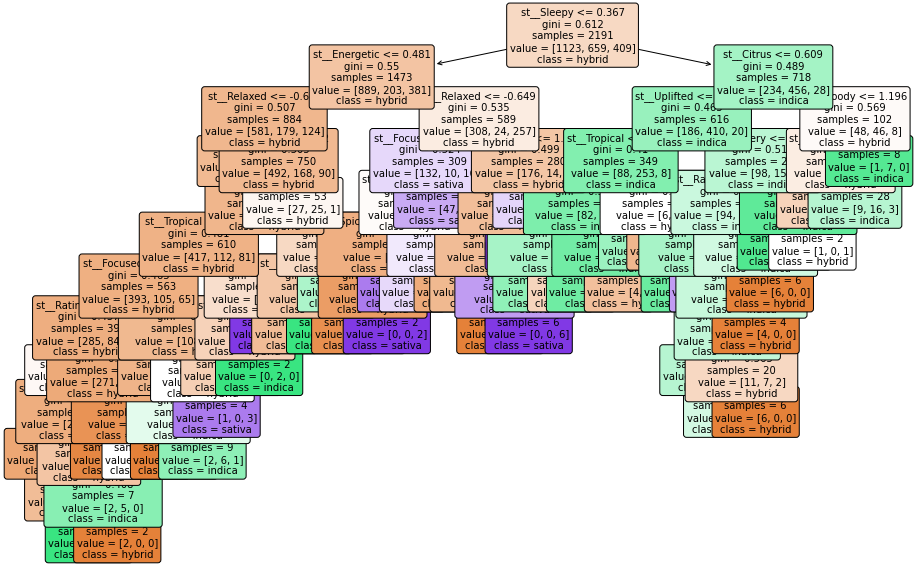

In [115]:
#DT Plot

plt.figure(figsize = (15, 10))
plot_tree(dt_pipeline.named_steps['dt'], feature_names = ct.fit_transform(X).columns, 
          class_names = [str(i) for i in np.unique(y)], filled = True, rounded = True, fontsize = 10)
plt.show()

In [116]:
#LDA Model Tuning

X = df.drop(["Strain", 'Type', 'Effects', 'Flavor'], axis = 1)
y = df['Type']

lda_pipeline = Pipeline(
    [("preprocessing", ct),
     ("lda", LinearDiscriminantAnalysis(solver = 'lsqr'))])

shrinkage = ['auto', 0.0001, 0.001, 0.01, 0.1, 1]
param_grid = {'lda__shrinkage': shrinkage}
gscv = GridSearchCV(lda_pipeline, param_grid, cv = 5, scoring = 'accuracy')
gscv_fitted = gscv.fit(X, y)
gscv_scores = gscv_fitted.cv_results_['mean_test_score']
pd.DataFrame(data = {"lda shrinkage": shrinkage, "accuracy": gscv_scores})

,lda shrinkage,accuracy
0,auto,0.618443
1,0.0001,0.628024
2,0.001,0.628024
3,0.01,0.627569
4,0.1,0.627570
5,1,0.620268


In [118]:
#LDA Model Fit

X = df.drop(["Strain", 'Type', 'Effects', 'Flavor'], axis = 1)
y = df['Type']

lda_pipeline = Pipeline(
    [("preprocessing", ct),
     ("lda", LinearDiscriminantAnalysis(solver = 'lsqr', shrinkage = 0.001))])

lda_pipeline.fit(X, y)
y_pred = lda_pipeline.predict(X)    
matrix = confusion_matrix(y, y_pred)
accuracy = accuracy_score(y, y_pred)

matrix, accuracy

(array([[778, 203, 142],
        [189, 461,   9],
        [205,  20, 184]]),
 0.6494751255134642)

In [119]:
#QDA Model Tuning

X = df.drop(["Strain", 'Type', 'Effects', 'Flavor'], axis = 1)
y = df['Type']

qda_pipeline = Pipeline(
    [("preprocessing", ct),
     ("qda", QuadraticDiscriminantAnalysis())])

reg_param = [0.5, 0.7, 0.9, 1.0]
param_grid = {'qda__reg_param': reg_param}
gscv = GridSearchCV(qda_pipeline, param_grid, cv = 5, scoring = 'accuracy')
gscv_fitted = gscv.fit(X, y)
gscv_scores = gscv_fitted.cv_results_['mean_test_score']
pd.DataFrame(data = {"qda reg_param": reg_param, "accuracy": gscv_scores})

,qda reg_param,accuracy
0,0.5,0.497505
1,0.7,0.529916
2,0.9,0.572831
3,1.0,0.619355


In [120]:
#QDA Model Fit

X = df.drop(["Strain", 'Type', 'Effects', 'Flavor'], axis = 1)
y = df['Type']

qda_pipeline = Pipeline(
    [("preprocessing", ct),
     ("qda", QuadraticDiscriminantAnalysis(reg_param = 1.0))])

qda_pipeline.fit(X, y)
y_pred = qda_pipeline.predict(X)    
accuracy = accuracy_score(y, y_pred)

matrix, accuracy

(array([[778, 203, 142],
        [189, 461,   9],
        [205,  20, 184]]),
 0.641259698767686)

In [93]:
#KNN Model Tuning

X = df.drop(["Strain", 'Type', 'Effects', 'Flavor'], axis = 1)
y = df['Type']

knn_pipeline = Pipeline(
    [("preprocessing", ct),
     ("knn", KNeighborsClassifier())])

n_neighbors = [3, 4, 5, 6, 7]
param_grid = {'knn__n_neighbors': n_neighbors}
gscv = GridSearchCV(knn_pipeline, param_grid, cv = 5, scoring = 'accuracy')
gscv_fitted = gscv.fit(X, y)
gscv_scores = gscv_fitted.cv_results_['mean_test_score']
pd.DataFrame(data = {"knn n_neighbors": n_neighbors, "accuracy": gscv_scores})

,knn n_neighbors,accuracy
0,3,0.534477
1,4,0.536301
2,5,0.550455
3,6,0.536299
4,7,0.543612


In [121]:
#KNN Model Fit

X = df.drop(["Strain", 'Type', 'Effects', 'Flavor'], axis = 1)
y = df['Type']

knn_pipeline = Pipeline(
    [("preprocessing", ct),
     ("knn", KNeighborsClassifier(n_neighbors = 5))])

knn_pipeline.fit(X, y)
y_pred = knn_pipeline.predict(X)    
matrix = confusion_matrix(y, y_pred)
accuracy = accuracy_score(y, y_pred)

matrix, accuracy

(array([[929, 135,  59],
        [243, 413,   3],
        [224,  23, 162]]),
 0.686444545869466)

In [95]:
df.head()

,Strain,Type,Rating,Effects,Flavor,Creative,Energetic,Tingly,Euphoric,Relaxed,...,Ammonia,Minty,Tree,Fruit,Butter,Pineapple,Tar,Rose,Plum,Pear
0,100-Og,hybrid,4.0,"Creative,Energetic,Tingly,Euphoric,Relaxed","Earthy,Sweet,Citrus",1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,98-White-Widow,hybrid,4.7,"Relaxed,Aroused,Creative,Happy,Energetic","Flowery,Violet,Diesel",1.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1024,sativa,4.4,"Uplifted,Happy,Relaxed,Energetic,Creative","Spicy/Herbal,Sage,Woody",1.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,13-Dawgs,hybrid,4.2,"Tingly,Creative,Hungry,Relaxed,Uplifted","Apricot,Citrus,Grapefruit",1.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,24K-Gold,hybrid,4.6,"Happy,Relaxed,Euphoric,Uplifted,Talkative","Citrus,Earthy,Orange",0.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Part Three: Multiclass from Binary

In [97]:
#OVR Dataset Transformation

df_ovr = df
df_ovr['Indica_yes'] = (df['Type'] == 'indica').astype(int)
df_ovr['Sativa_yes'] = (df['Type'] == 'sativa').astype(int)
df_ovr['Hybrid_yes'] = (df['Type'] == 'hybrid').astype(int)

In [126]:
#Log Indica OVR Tuning

X = df_ovr.drop(["Strain", 'Type', 'Effects', 'Flavor', 'Indica_yes', 'Sativa_yes', 'Hybrid_yes'], axis = 1)
y = df_ovr['Indica_yes']

log_pipeline = Pipeline(
    [("preprocessing", ct),
     ("log", LogisticRegression())])

C = [0.01, 0.02, 0.03]
param_grid = {'log__C': C}
gscv = GridSearchCV(log_pipeline, param_grid, cv = 5, scoring = 'accuracy')
gscv_fitted = gscv.fit(X, y)
gscv_scores = gscv_fitted.cv_results_['mean_test_score']
pd.DataFrame(data = {"log reg_param": C, "accuracy": gscv_scores})

,svr reg_param,accuracy
0,0.01,0.793712
1,0.02,0.793714
2,0.03,0.792344


In [133]:
#SVC Indica OVR Tuning

X = df_ovr.drop(["Strain", 'Type', 'Effects', 'Flavor', 'Indica_yes', 'Sativa_yes', 'Hybrid_yes'], axis = 1)
y = df_ovr['Indica_yes']

svc_pipeline = Pipeline(
    [("preprocessing", ct),
     ("svc", SVC())])

C = [0.5, 1, 1.5, 2]
param_grid = {'svc__C': C}
gscv = GridSearchCV(svc_pipeline, param_grid, cv = 5, scoring = 'accuracy')
gscv_fitted = gscv.fit(X, y)
gscv_scores = gscv_fitted.cv_results_['mean_test_score']
pd.DataFrame(data = {"svc reg_param": C, "accuracy": gscv_scores})

,svc reg_param,accuracy
0,0.5,0.774545
1,1.0,0.775001
2,1.5,0.775914
3,2.0,0.766337


In [137]:
#Log Sativa OVR Tuning

X = df_ovr.drop(["Strain", 'Type', 'Effects', 'Flavor', 'Indica_yes', 'Sativa_yes', 'Hybrid_yes'], axis = 1)
y = df_ovr['Sativa_yes']

log_pipeline = Pipeline(
    [("preprocessing", ct),
     ("log", LogisticRegression())])

C = [0.005, 0.01, 0.015]
param_grid = {'log__C': C}
gscv = GridSearchCV(log_pipeline, param_grid, cv = 5, scoring = 'accuracy')
gscv_fitted = gscv.fit(X, y)
gscv_scores = gscv_fitted.cv_results_['mean_test_score']
pd.DataFrame(data = {"log reg_param": C, "accuracy": gscv_scores})

,log reg_param,accuracy
0,0.005,0.821999
1,0.010,0.825196
2,0.015,0.822457


In [142]:
#SVC Sativa OVR Tuning

X = df_ovr.drop(["Strain", 'Type', 'Effects', 'Flavor', 'Indica_yes', 'Sativa_yes', 'Hybrid_yes'], axis = 1)
y = df_ovr['Sativa_yes']

svc_pipeline = Pipeline(
    [("preprocessing", ct),
     ("svc", SVC())])

C = [0.1, 1, 2, 3]
param_grid = {'svc__C': C}
gscv = GridSearchCV(svc_pipeline, param_grid, cv = 5, scoring = 'accuracy')
gscv_fitted = gscv.fit(X, y)
gscv_scores = gscv_fitted.cv_results_['mean_test_score']
pd.DataFrame(data = {"svc reg_param": C, "accuracy": gscv_scores})

,svc reg_param,accuracy
0,0.1,0.813327
1,1.0,0.819261
2,2.0,0.819260
3,3.0,0.815152


In [146]:
#Log Hybrid OVR Tuning

X = df_ovr.drop(["Strain", 'Type', 'Effects', 'Flavor', 'Indica_yes', 'Sativa_yes', 'Hybrid_yes'], axis = 1)
y = df_ovr['Hybrid_yes']

log_pipeline = Pipeline(
    [("preprocessing", ct),
     ("log", LogisticRegression())])

C = [0.001, 0.005, 0.01]
param_grid = {'log__C': C}
gscv = GridSearchCV(log_pipeline, param_grid, cv = 5, scoring = 'accuracy')
gscv_fitted = gscv.fit(X, y)
gscv_scores = gscv_fitted.cv_results_['mean_test_score']
pd.DataFrame(data = {"log reg_param": C, "accuracy": gscv_scores})

,log reg_param,accuracy
0,0.001,0.614329
1,0.005,0.617528
2,0.010,0.614790


In [148]:
#SVC Hybrid OVR Tuning

X = df_ovr.drop(["Strain", 'Type', 'Effects', 'Flavor', 'Indica_yes', 'Sativa_yes', 'Hybrid_yes'], axis = 1)
y = df_ovr['Hybrid_yes']

svc_pipeline = Pipeline(
    [("preprocessing", ct),
     ("svc", SVC())])

C = [0.5, 1, 1.5]
param_grid = {'svc__C': C}
gscv = GridSearchCV(svc_pipeline, param_grid, cv = 5, scoring = 'accuracy')
gscv_fitted = gscv.fit(X, y)
gscv_scores = gscv_fitted.cv_results_['mean_test_score']
pd.DataFrame(data = {"svc reg_param": C, "accuracy": gscv_scores})

,svc reg_param,accuracy
0,0.5,0.608850
1,1.0,0.614785
2,1.5,0.612958


In [157]:
#Fitting all 6 OVR Models

def get_accuracy(model, ovr):
    X = df_ovr.drop(["Strain", 'Type', 'Effects', 'Flavor', 'Indica_yes', 'Sativa_yes', 'Hybrid_yes'], axis = 1)
    y = df_ovr[ovr]
    
    def get_parameter(model, ovr):
        value_mappings = {
        ('log', 'Indica_yes'): 0.02,
        ('svc', 'Indica_yes'): 1.5,
        ('log', 'Sativa_yes'): 0.01,
        ('svc', 'Sativa_yes'): 1,
        ('log', 'Sativa_yes'): 0.05,
        ('svc', 'Sativa_yes'): 1}
        
        return value_mappings.get((model, ovr), 1)
    
    reg_param = get_parameter(model, ovr)
    
    if (model == 'log'):
        log_pipeline = Pipeline(
            [("preprocessing", ct),
             ("log", LogisticRegression(C = reg_param))])
        log_pipeline.fit(X, y)
        y_pred = log_pipeline.predict(X)
        
    if (model == 'svc'):
        svc_pipeline = Pipeline(
            [("preprocessing", ct),
             ("svc", SVC(C = reg_param))])
        svc_pipeline.fit(X, y)
        y_pred = svc_pipeline.predict(X)
    
    accuracy = accuracy_score(y, y_pred)
    data = pd.DataFrame(data = {"Model": [model], "OVR": [ovr], "Accuracy": [accuracy]})
    
    return data


ovr_versions = ['Indica_yes', 'Sativa_yes', 'Hybrid_yes']
models = ['log', 'svc']

columns = ['Model', 'OVR', 'Accuracy']
ovr_df = pd.DataFrame(columns = columns)
for o in ovr_versions:
    for m in models:
        acc = get_accuracy(model = m, ovr = o)
        ovr_df = pd.concat([ovr_df, acc], ignore_index = True)

ovr_df

,Model,OVR,Accuracy
0,log,Indica_yes,0.816066
1,svc,Indica_yes,0.860794
2,log,Sativa_yes,0.838886
3,svc,Sativa_yes,0.866271
4,log,Hybrid_yes,0.653583
5,svc,Hybrid_yes,0.741214


 - SVC Sativa was the strongest OVR model
 - SVC Indica was very strong as well
 - Log models consistently underperformed compared to SVC
 - Hybrid was toughest to predict as expected. 

In [160]:
#OVO Dataset Transformation

df_ovoA = df[df['Type'].isin(['indica', 'sativa'])]
df_ovoB = df[df['Type'].isin(['indica', 'hybrid'])]
df_ovoC = df[df['Type'].isin(['hybrid', 'sativa'])]

In [166]:
#Log Indica-Sativa OVO Tuning

X = df_ovoA.drop(["Strain", 'Type', 'Effects', 'Flavor'], axis = 1)
y = df_ovoA['Type']

log_pipeline = Pipeline(
    [("preprocessing", ct),
     ("log", LogisticRegression())])

C = [0.005, 0.01, 0.015]
param_grid = {'log__C': C}
gscv = GridSearchCV(log_pipeline, param_grid, cv = 5, scoring = 'accuracy')
gscv_fitted = gscv.fit(X, y)
gscv_scores = gscv_fitted.cv_results_['mean_test_score']
pd.DataFrame(data = {"log reg_param": C, "accuracy": gscv_scores})

,log reg_param,accuracy
0,0.005,0.857694
1,0.010,0.864249
2,0.015,0.858628


In [165]:
#SVC Indica-Sativa OVO Tuning

X = df_ovoA.drop(["Strain", 'Type', 'Effects', 'Flavor'], axis = 1)
y = df_ovoA['Type']

svc_pipeline = Pipeline(
    [("preprocessing", ct),
     ("svc", SVC())])

C = [1, 1.5, 2]
param_grid = {'svc__C': C}
gscv = GridSearchCV(svc_pipeline, param_grid, cv = 5, scoring = 'accuracy')
gscv_fitted = gscv.fit(X, y)
gscv_scores = gscv_fitted.cv_results_['mean_test_score']
pd.DataFrame(data = {"svc reg_param": C, "accuracy": gscv_scores})

,svc reg_param,accuracy
0,1.0,0.841815
1,1.5,0.844614
2,2.0,0.844610


In [170]:
#Log Indica-Hybrid OVO Tuning

X = df_ovoB.drop(["Strain", 'Type', 'Effects', 'Flavor'], axis = 1)
y = df_ovoB['Type']

log_pipeline = Pipeline(
    [("preprocessing", ct),
     ("log", LogisticRegression())])

C = [0.001, 0.005, 0.01]
param_grid = {'log__C': C}
gscv = GridSearchCV(log_pipeline, param_grid, cv = 5, scoring = 'accuracy')
gscv_fitted = gscv.fit(X, y)
gscv_scores = gscv_fitted.cv_results_['mean_test_score']
pd.DataFrame(data = {"log reg_param": C, "accuracy": gscv_scores})

,log reg_param,accuracy
0,0.001,0.698629
1,0.005,0.750848
2,0.010,0.750288


In [171]:
#SVC Indica-Hybrid OVO Tuning

X = df_ovoB.drop(["Strain", 'Type', 'Effects', 'Flavor'], axis = 1)
y = df_ovoB['Type']

svc_pipeline = Pipeline(
    [("preprocessing", ct),
     ("svc", SVC())])

C = [0.1, 0.5, 1]
param_grid = {'svc__C': C}
gscv = GridSearchCV(svc_pipeline, param_grid, cv = 5, scoring = 'accuracy')
gscv_fitted = gscv.fit(X, y)
gscv_scores = gscv_fitted.cv_results_['mean_test_score']
pd.DataFrame(data = {"svc reg_param": C, "accuracy": gscv_scores})

,svc reg_param,accuracy
0,0.1,0.718867
1,0.5,0.731777
2,1.0,0.730101


In [174]:
#Log Hybrid-Sativa OVO Tuning

X = df_ovoC.drop(["Strain", 'Type', 'Effects', 'Flavor'], axis = 1)
y = df_ovoC['Type']

log_pipeline = Pipeline(
    [("preprocessing", ct),
     ("log", LogisticRegression())])

C = [0.005, 0.01, 0.02]
param_grid = {'log__C': C}
gscv = GridSearchCV(log_pipeline, param_grid, cv = 5, scoring = 'accuracy')
gscv_fitted = gscv.fit(X, y)
gscv_scores = gscv_fitted.cv_results_['mean_test_score']
pd.DataFrame(data = {"log reg_param": C, "accuracy": gscv_scores})

,log reg_param,accuracy
0,0.005,0.748034
1,0.010,0.749341
2,0.020,0.747380


In [176]:
#SVC Indica-Sativa OVO Tuning

X = df_ovoC.drop(["Strain", 'Type', 'Effects', 'Flavor'], axis = 1)
y = df_ovoC['Type']

svc_pipeline = Pipeline(
    [("preprocessing", ct),
     ("svc", SVC())])

C = [1, 1.5, 2]
param_grid = {'svc__C': C}
gscv = GridSearchCV(svc_pipeline, param_grid, cv = 5, scoring = 'accuracy')
gscv_fitted = gscv.fit(X, y)
gscv_scores = gscv_fitted.cv_results_['mean_test_score']
pd.DataFrame(data = {"svc reg_param": C, "accuracy": gscv_scores})

,svc reg_param,accuracy
0,1.0,0.738241
1,1.5,0.746071
2,2.0,0.740197


In [179]:
def get_accuracy(model, name, dataframe):
    
    X = dataframe.drop(["Strain", 'Type', 'Effects', 'Flavor'], axis = 1)
    y = dataframe['Type']
    
    def get_parameter(model, name):
        value_mappings = {
        ('log', 'Indica-Sativa'): 0.01,
        ('svc', 'Indica-Sativa'): 1.5,
        ('log', 'Indica-Hybrid'): 0.005,
        ('svc', 'Indica-Hybrid'): 0.5,
        ('log', 'Sativa-Hybrid'): 0.01,
        ('svc', 'Sativa-Hybrid'): 1.5}
        
        return value_mappings.get((model, name), 1)
    
    reg_param = get_parameter(model, name)
    
    if (model == 'log'):
        log_pipeline = Pipeline(
            [("preprocessing", ct),
             ("log", LogisticRegression(C = reg_param))])
        log_pipeline.fit(X, y)
        y_pred = log_pipeline.predict(X)
        
    if (model == 'svc'):
        svc_pipeline = Pipeline(
            [("preprocessing", ct),
             ("svc", SVC(C = reg_param))])
        svc_pipeline.fit(X, y)
        y_pred = svc_pipeline.predict(X)
    
    accuracy = accuracy_score(y, y_pred)
    data = pd.DataFrame(data = {"Model": [model], "OVO": [name], "Accuracy": [accuracy]})
    
    return data


dataframes = {'Indica-Sativa': df_ovoA, 'Indica-Hybrid': df_ovoB, 'Sativa-Hybrid': df_ovoC}
models = ['log', 'svc']

columns = ['Model', 'OVO', 'Accuracy']
ovo_df = pd.DataFrame(columns = columns)
for n, d in dataframes.items():
    for m in models:
        row = get_accuracy(model = m, name = n, dataframe = d)
        ovo_df = pd.concat([ovo_df, row], ignore_index = True)

ovo_df

,Model,OVO,Accuracy
0,log,Indica-Sativa,0.882959
1,svc,Indica-Sativa,0.949438
2,log,Indica-Hybrid,0.773288
3,svc,Indica-Hybrid,0.774972
4,log,Sativa-Hybrid,0.768277
5,svc,Sativa-Hybrid,0.851828


- SVC Indica-Sativa was the strongest OVO model as well as strongest model thus far
- Indica-Sativa OVO models performed significantly better than others
- Log again did not perform as well as SVC
- Log Sativa-Hybrid had the lowest accuraccy of the OVO models

Sklearn's Logistic Regression function automatically switches between 'ovr' and 'multinomial' depending on whether the target variable is binary. For SVC, the function will default to using 'ovr', unless the 'ovo' parameter is specified. 